## Python Frontend
This notebook demonstrates the Python frontend to MPB.

In [2]:
import datetime
import time
import yaml
from mpb import MPB, MultipleMPB
import matplotlib as mpl
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['pdf.fonttype'] = 42
from copy import deepcopy
from argparse import ArgumentParser
from yaml.loader import SafeLoader
import os
import random
import string


setup_yaml_file = "sg-pairs-atc-1.yaml"
processes = 6
sampling_fns = ["dijkstra", "hybrid"]

sampling_functions = sampling_fns
print("Running these sampling functions: ")
print(sampling_functions)
with open(setup_yaml_file) as f:
    setup = yaml.load(f, SafeLoader)

print("***************************************************************")
print("Successfully read the yaml file containing {} start-goal pairs.", len(setup['sg']))
print("***************************************************************")

pool = MultipleMPB()
# Basic Setup
mpb = MPB()
mpb["ompl.seed"] = -1  # set the seed of the OMPL planners
mpb.set_planners(['informed_rrt_star'])
mpb.set_steer_functions(['car'])
mpb["steer.car_turning_radius"] = 1.0
mpb["steer.sampling_resolution"] = 0.001
mpb["max_planning_time"] = float(setup["max_planning_time"])
mpb["ompl.geometric_planner_settings.RRTstar.delay_collision_checking"] = "0"
mpb["ompl.geometric_planner_settings.RRTstar.goal_bias"] = "0.01"
mpb["ompl.geometric_planner_settings.InformedRRTstar.delay_collision_checking"] = "0"
mpb["ompl.geometric_planner_settings.InformedRRTstar.goal_bias"] = "0.01"

mpb["env.collision.robot_shape_source"] = os.path.abspath(os.getcwd() + "/../maps/simple_robot.yaml")
mpb.set_image_yaml_env(os.path.abspath(os.getcwd() + "/../" + setup["occmap_file"]))
cliff_map_file = os.path.abspath(os.getcwd() + "/../" + setup["cliff_map_file"])
intensity_map_file = os.path.abspath(os.getcwd() + "/../" + setup["intensity_map_file"])
gmmt_map_file = os.path.abspath(os.getcwd() + "/../" + setup["gmmt_map_file"])

cost_fns = setup["cost_fns"]
cost_fn_map = {"dtc": cliff_map_file, "cliff": cliff_map_file, "intensity": intensity_map_file,
               "gmmt": gmmt_map_file}

mpb["mod.weight_dtc"] = 0.02
mpb["mod.weight_cliff"] = 0.1
mpb["mod.weight_gmmt"] = 0.1
mpb["mod.weight_intensity"] = 0.2


Running these sampling functions: 
['dijkstra', 'hybrid']
***************************************************************
Successfully read the yaml file containing {} start-goal pairs. 1
***************************************************************


****************************************
********* Running: test-atc-scenario1 *********
****************************************
Available memory: 11.60 GB, limiting each MPB process to 41.7% usage (4.83 GB).
Creating pool of 6 processes.
Running MPB with ID gmmt-hybrid (log file at test-atc-scenario1-2023-01-16_22-43-42tcjpsqruu8/gmmt-hybrid.log)...Running MPB with ID cliff-dijkstra (log file at test-atc-scenario1-2023-01-16_22-43-42tcjpsqruu8/cliff-dijkstra.log)...Running MPB with ID gmmt-dijkstra (log file at test-atc-scenario1-2023-01-16_22-43-42tcjpsqruu8/gmmt-dijkstra.log)...Running MPB with ID dtc-hybrid (log file at test-atc-scenario1-2023-01-16_22-43-42tcjpsqruu8/dtc-hybrid.log)...Running MPB with ID dtc-dijkstra (log file at test-atc-scenario1-2023-01-16_22-43-42tcjpsqruu8/dtc-dijkstra.log)...Running MPB with ID cliff-hybrid (log file at test-atc-scenario1-2023-01-16_22-43-42tcjpsqruu8/cliff-hybrid.log)...






cliff-hybrid:   0%|                                      | 0/10 [00:00<?, ?it/s]

gmmt-dijkstra: 100%|████████████████████████████| 10/10 [01:32<00:00,  9.20s/it]


Benchmark 0 (gmmt-dijkstra) finished successfully.
Running MPB with ID intensity-dijkstra (log file at test-atc-scenario1-2023-01-16_22-43-42tcjpsqruu8/intensity-dijkstra.log)...


gmmt-hybrid: 100%|██████████████████████████████| 10/10 [01:33<00:00,  9.33s/it]


Benchmark 1 (gmmt-hybrid) finished successfully.
Running MPB with ID intensity-hybrid (log file at test-atc-scenario1-2023-01-16_22-43-42tcjpsqruu8/intensity-hybrid.log)...


dtc-dijkstra: 100%|█████████████████████████████| 10/10 [01:37<00:00,  9.78s/it]


Benchmark 4 (dtc-dijkstra) finished successfully.


dtc-hybrid: 100%|███████████████████████████████| 10/10 [01:37<00:00,  9.80s/it]


Benchmark 5 (dtc-hybrid) finished successfully.


cliff-dijkstra: 100%|███████████████████████████| 10/10 [01:38<00:00,  9.88s/it]


Benchmark 2 (cliff-dijkstra) finished successfully.


cliff-hybrid: 100%|█████████████████████████████| 10/10 [01:40<00:00, 10.06s/it]


Benchmark 3 (cliff-hybrid) finished successfully.


intensity-dijkstra: 100%|███████████████████████| 10/10 [01:31<00:00,  9.10s/it]


Benchmark 6 (intensity-dijkstra) finished successfully.


intensity-hybrid: 100%|█████████████████████████| 10/10 [01:31<00:00,  9.19s/it]


Benchmark 7 (intensity-hybrid) finished successfully.
All benchmarks succeeded.


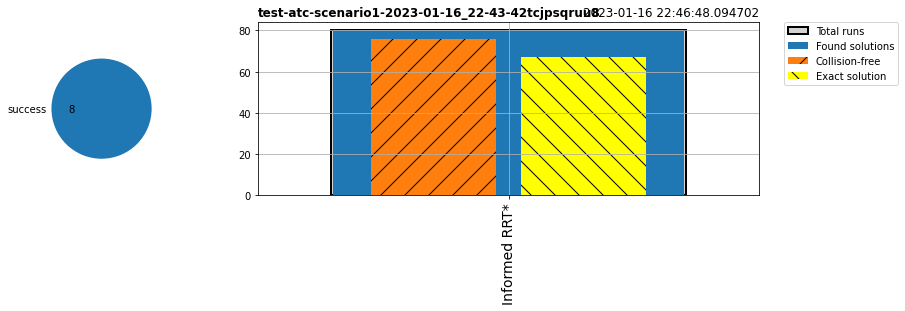

In [3]:
for sgs in setup['sg']:
    print("****************************************")
    print("********* Running: {} *********".format(sgs["name"]))
    print("****************************************")

    mpbs = dict()
    result_file_names = []

    mpb.set_start(sgs["start"][0],sgs["start"][1],sgs["start"][2])
    mpb.set_goal(sgs["goal"][0],sgs["goal"][1],sgs["goal"][2])
    results_folder_prefix = sgs["name"]

    for cost_fn in cost_fns:

        if "dijkstra" in sampling_functions or len(sampling_functions) == 0:
            dijkstra_mpb = deepcopy(mpb)
            dijkstra_mpb["ompl.sampler"] = "dijkstra"
            dijkstra_mpb["mod.dijkstra_cell_size"] = 0.5
            dijkstra_mpb["mod.sampling_bias"] = 0.05
            dijkstra_mpb.set_id('{}-{}'.format(cost_fn, 'dijkstra'))
            dijkstra_mpb["ompl.intensity_map_file_name"] = intensity_map_file
            dijkstra_mpb["ompl.optimization_objective"] = cost_fn
            dijkstra_mpb["mod.mod_file_name"] = cost_fn_map[cost_fn]
            mpbs['{}-{}-{}'.format(sgs["name"], cost_fn, 'dijkstra')] = dijkstra_mpb
            result_file_names.append("{}/{}-{}_results.json".format(results_folder_prefix, cost_fn, 'dijkstra'))

        if "uniform" in sampling_functions or len(sampling_functions) == 0:
            uniform_mpb = deepcopy(mpb)
            uniform_mpb.set_planners(['rrt_star'])
            uniform_mpb["ompl.sampler"] = ""
            uniform_mpb.set_id('{}-{}'.format(cost_fn, 'uniform'))
            uniform_mpb["ompl.intensity_map_file_name"] = intensity_map_file
            uniform_mpb["ompl.optimization_objective"] = cost_fn
            uniform_mpb["mod.mod_file_name"] = cost_fn_map[cost_fn]
            mpbs['{}-{}-{}'.format(sgs["name"], cost_fn, 'uniform')] = uniform_mpb
            result_file_names.append("{}/{}-{}_results.json".format(results_folder_prefix, cost_fn, 'uniform'))

        if "ellipse" in sampling_functions or len(sampling_functions) == 0:
            ellipse_mpb = deepcopy(mpb)
            ellipse_mpb["ompl.sampler"] = "ellipse"
            ellipse_mpb.set_id('{}-{}'.format(cost_fn, 'ellipse'))
            ellipse_mpb["ompl.intensity_map_file_name"] = intensity_map_file
            ellipse_mpb["ompl.optimization_objective"] = cost_fn
            ellipse_mpb["mod.mod_file_name"] = cost_fn_map[cost_fn]
            mpbs['{}-{}-{}'.format(sgs["name"], cost_fn, 'ellipse')] = ellipse_mpb
            result_file_names.append("{}/{}-{}_results.json".format(results_folder_prefix, cost_fn, 'ellipse'))

        if "intensity" in sampling_functions or len(sampling_functions) == 0:
            intensity_mpb = deepcopy(mpb)
            intensity_mpb["ompl.sampler"] = "intensity"
            intensity_mpb.set_id('{}-{}'.format(cost_fn, 'intensity'))
            intensity_mpb["mod.sampling_bias"] = 0.05
            intensity_mpb["ompl.intensity_map_file_name"] = intensity_map_file
            intensity_mpb["ompl.optimization_objective"] = cost_fn
            intensity_mpb["mod.mod_file_name"] = cost_fn_map[cost_fn]
            mpbs['{}-{}-{}'.format(sgs["name"], cost_fn, 'intensity')] = intensity_mpb
            result_file_names.append("{}/{}-{}_results.json".format(results_folder_prefix, cost_fn, 'intensity'))

        if "hybrid" in sampling_functions or len(sampling_functions) == 0:
            hybrid_mpb = deepcopy(mpb)
            hybrid_mpb["ompl.sampler"] = "hybrid"
            hybrid_mpb.set_id('{}-{}'.format(cost_fn, 'hybrid'))
            hybrid_mpb["mod.dijkstra_cell_size"] = 0.5
            hybrid_mpb["mod.sampling_bias"] = 0.05
            hybrid_mpb["ompl.intensity_map_file_name"] = intensity_map_file
            hybrid_mpb["ompl.optimization_objective"] = cost_fn
            hybrid_mpb["mod.mod_file_name"] = cost_fn_map[cost_fn]
            mpbs['{}-{}-{}'.format(sgs["name"], cost_fn, 'hybrid')] = hybrid_mpb
            result_file_names.append("{}/{}-{}_results.json".format(results_folder_prefix, cost_fn, 'hybrid'))

    for mpb in mpbs.values():
        pool.benchmarks.append(mpb)

    # for key in mpbs:
    #     print("Running {}".format(key))
    #     mpbs[key].run(id=key, runs=int(setup['repeats']), subfolder=os.getcwd() + "/" + results_folder_prefix)
    ts = time.time()
    name = results_folder_prefix + "-" + datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d_%H-%M-%S') + ''.join(random.SystemRandom().choice(string.ascii_lowercase + string.digits) for _ in range(10))
    pool.run_parallel(id=name, runs=int(setup['repeats']), use_subfolder=True, processes=processes)


Run the motion planning benchmark:

In [8]:
MPB.merge(mpbs, target_filename="test-atc-combined.json", plan_names=list(mpbs.keys()))

No results file exists for MPB test-atc-scenario1-gmmt-dijkstra. Skipping.
No results file exists for MPB test-atc-scenario1-gmmt-hybrid. Skipping.
No results file exists for MPB test-atc-scenario1-cliff-dijkstra. Skipping.
No results file exists for MPB test-atc-scenario1-cliff-hybrid. Skipping.
No results file exists for MPB test-atc-scenario1-dtc-dijkstra. Skipping.
No results file exists for MPB test-atc-scenario1-dtc-hybrid. Skipping.
No results file exists for MPB test-atc-scenario1-intensity-dijkstra. Skipping.
No results file exists for MPB test-atc-scenario1-intensity-hybrid. Skipping.
Successfully merged [test-atc-scenario1-gmmt-dijkstra, test-atc-scenario1-gmmt-hybrid, test-atc-scenario1-cliff-dijkstra, test-atc-scenario1-cliff-hybrid, test-atc-scenario1-dtc-dijkstra, test-atc-scenario1-dtc-hybrid, test-atc-scenario1-intensity-dijkstra, test-atc-scenario1-intensity-hybrid] into test-atc-combined.json.


Visualizing atc-scenario1-new-combined.json...


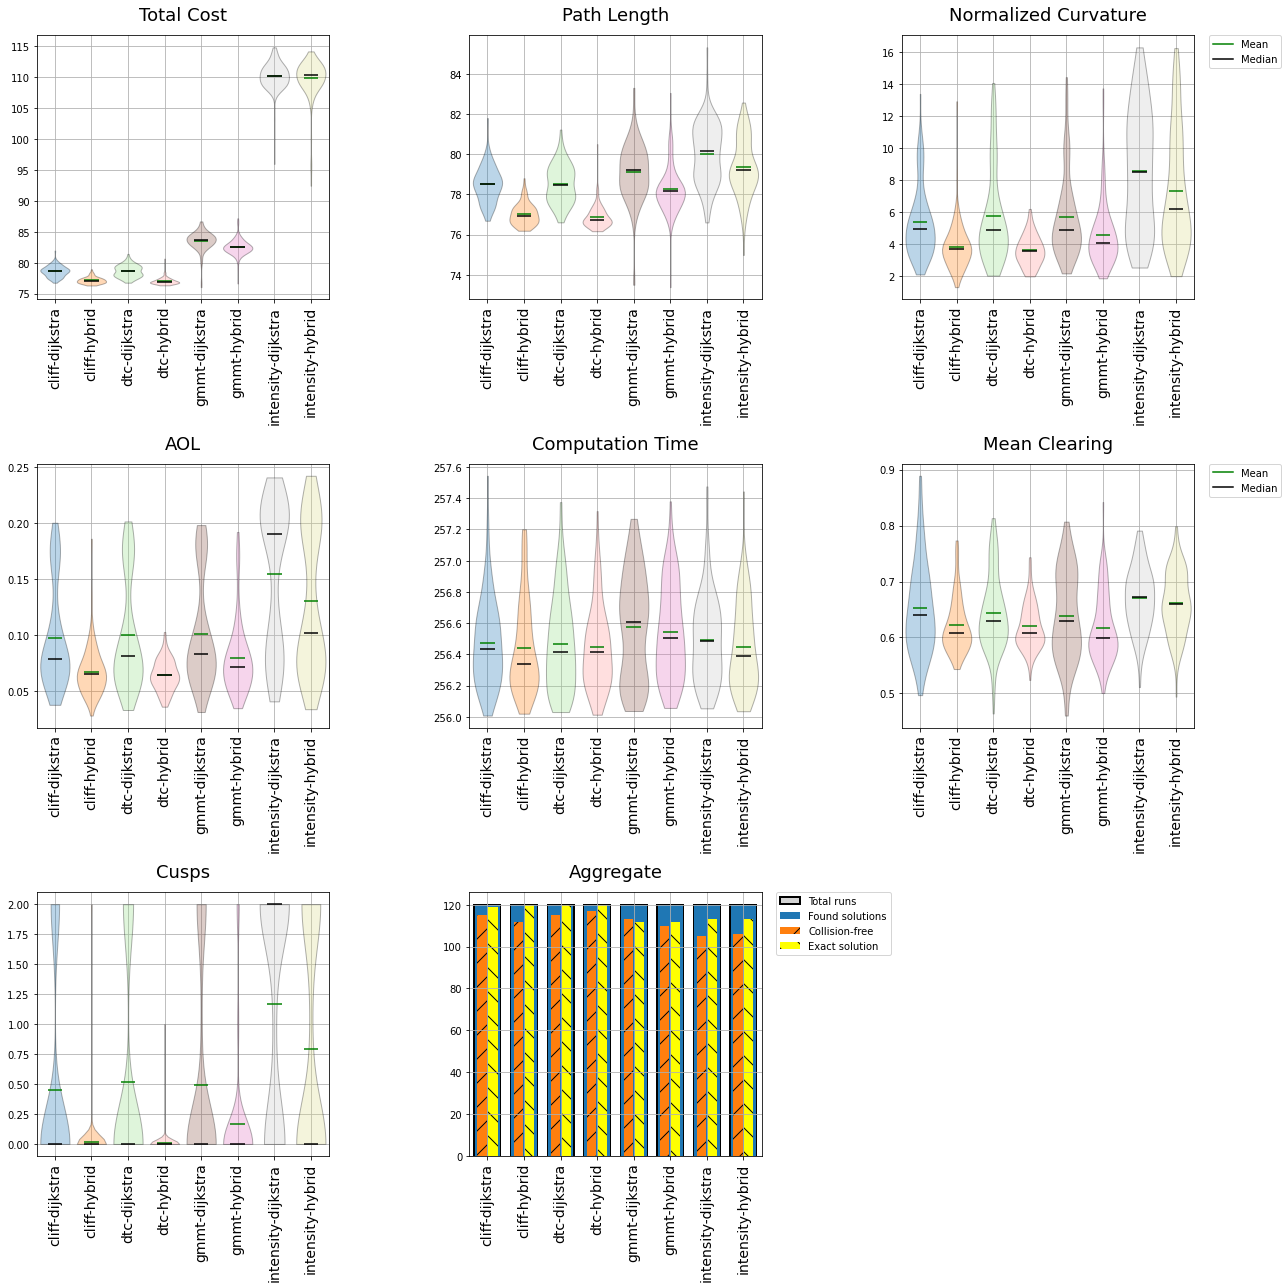

In [10]:
from plot_stats import plot_planner_stats
plot_planner_stats('atc-scenario1-new-combined.json', num_colors=8, ticks_rotation=90)

Visualizing atc-scenario1-new-combined.json...
########## SETTINGS ##########
MoD weights: (1) CLiFF = 0.1,
             (2) GMMT  = 0.1,
             (3) DTC   = 0.02
##############################


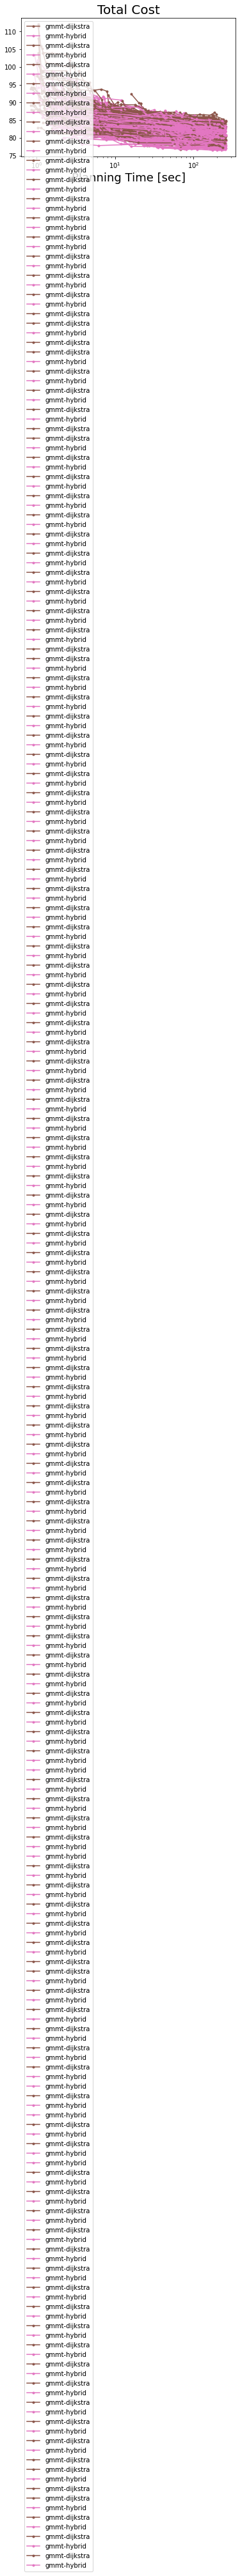

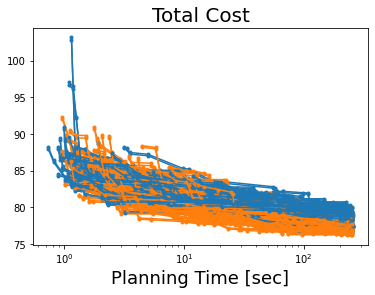

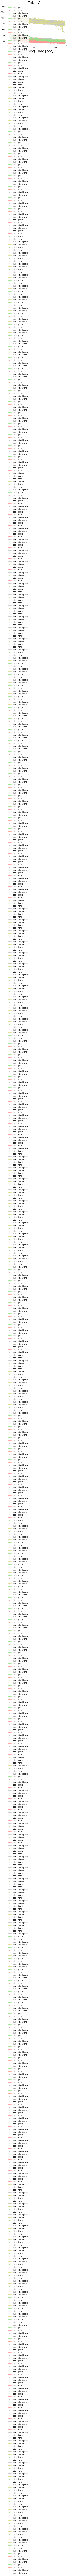

In [11]:
from plot_convergence_mod import plot_convergence
plot_convergence('atc-scenario1-new-combined.json', num_colors=8, ticks_rotation=90)